In [5]:
#import

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import MDAnalysis as mda
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from OPLS_MD import OPLS, OPLS_PLS, PLS
import shap

In [32]:
# read and generate data

#data_path = '/wrk/romiromi/work/'
data_path = '/home/romiromi/work/bondflow_data/'

In [48]:
dist= np.load(data_path +f"ma_distance_map.npy")
bond_names = np.load(data_path + "ma_contact_map_names.npy")
# array from 0 to 1 with 100 elements
projs = np.linspace(0, 1, 100)

print(dist.shape)
print(bond_names.shape)
print(projs.shape)

#dist = dist.T
#print(dist.shape)

(100, 36)
(36,)
(100,)


In [49]:
# Optimize the n_components

train_split = 0.5
data = {}
maxcomp = 5
stride = 1
label = "ionic_bonds"


data[label] = {}
data[label]["ncomp"] = []
data[label]["test_scores"] = []
data[label]["train_scores"] = []
data[label]["test_scores_opls"] = []
data[label]["train_scores_opls"] = []

# Test and train sets
X_train, X_test, \
y_train, y_test = train_test_split(
                    dist, projs,
                    test_size=train_split,
                    random_state=42
                )

#print(f"X_train = shape{X_train.shape}\nX_test  = shape{X_test.shape}")
#print(f"y_train = shape{y_train.shape}\ny_test  = shape{y_test.shape}")

print(f"Now running PLS...")

# call pls
# iterate over different number of components
for ncomp in range(1,maxcomp+1):
    print(f"Building models with {ncomp} components", end="\r")
    pls      = PLS(n_components=ncomp).fit(X_train, y_train)
    opls = OPLS_PLS(pls_components=ncomp).fit(X_train, y_train)

    data[label]["ncomp"].append(ncomp)
    data[label]["test_scores"].append(pls.score(X_test, y_test))
    data[label]["train_scores"].append(pls.score(X_train, y_train))
    data[label]["test_scores_opls"].append(opls.score(X_test, y_test))
    data[label]["train_scores_opls"].append(opls.score(X_train, y_train))
    
    print(f"Train score: {data[label]['train_scores_opls'][ncomp-1]}")
    print(f"Test score: {data[label]['test_scores_opls'][ncomp-1]}")


print(f"Done! Built models up to {maxcomp} components.")

Now running PLS...
Train score: 0.9992458456427826ts
Test score: 0.9993394066831877
Train score: 0.9995478699784288ts
Test score: 0.9995179639395155
Train score: 0.9999938142023267ts
Test score: 0.9999915760854187
Train score: 0.9999979586292282ts
Test score: 0.999996904758378
Train score: 0.999998752336469nts
Test score: 0.9999979431788482
Done! Built models up to 5 components.


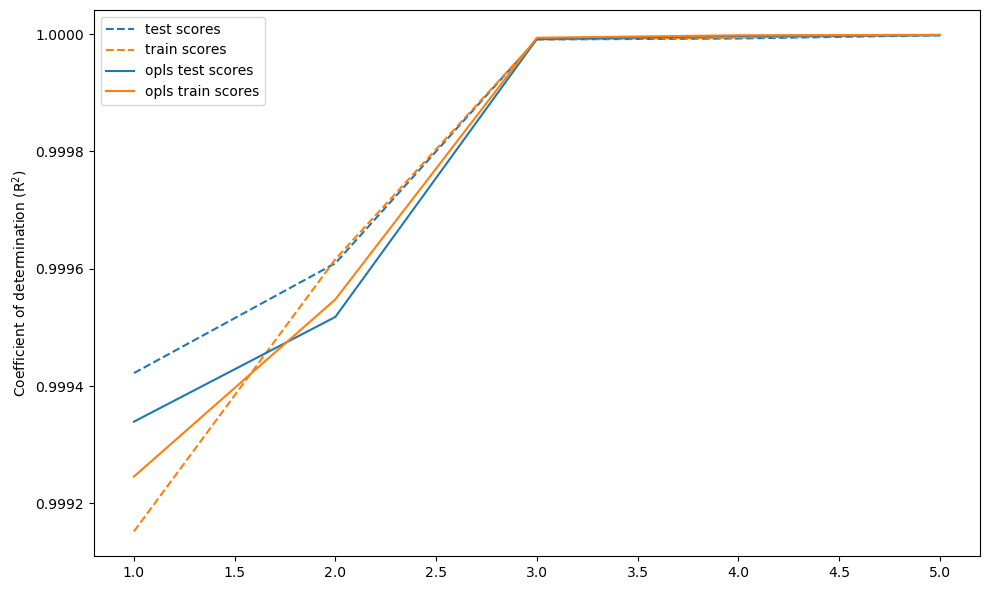

In [50]:
# Plot scores over numbers of components
fig,ax = plt.subplots(1)

key = 'ionic_bonds'
    
ax.plot(data[key]["ncomp"], data[key]["test_scores"],  "--", c="C0", label="test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores"], "--", c="C1", label="train scores")
ax.plot(data[key]["ncomp"], data[key]["test_scores_opls"],   c="C0", label="opls test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores_opls"],  c="C1", label="opls train scores")

ax.legend()
ax.set_ylabel("Coefficient of determination (R$^2$)")

fig.set_size_inches(10,6)
fig.tight_layout()

In [51]:
# functions

def plot_residue_importance(X, y, bond_list,  N=3, title = "", ncomp=2):

    # number of components
    #ncomp  = 5

    # Normalize the data
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    y_reshaped = np.reshape(y, (-1, 1))
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_reshaped)

    # Build the PLS model
    opls = OPLS_PLS(pls_components=ncomp).fit(X, y)
    # Get the PLS components
    X_pls = opls.transform(X)
    # Get the coefficients
    coefficients = opls.pls_.coef_
    coefficients = coefficients.flatten()
    print(len(coefficients))
    sorted_coeffs = sorted(coefficients,reverse=True)


    # Sort bonds by importance

    sorted_pairs = sorted(zip(bond_list, coefficients), reverse=True)
    sorted_bonds =  [item for item, _  in sorted_pairs]


    # Get the first N residues
    top_bonds = sorted_bonds[:N]
    top_coeff = sorted_coeffs[:N]
    print(top_bonds)

    # Create the waterfall plot
    #plt.bar(range(N), [val for  val in top_coeff])
    #plt.xticks(range(N),[f"{bond}"  for bond in top_bonds], rotation = 'vertical',  fontsize=8)
    #plt.xlabel('Residue')
    #plt.ylabel('Importance')
    #plt.title(f'Top {N} Important Residues {title}')
    #plt.tight_layout()
    #plt.show()

    # Create the waterfall plot
    plt.barh(range(N), [val for val in top_coeff])
    plt.yticks(range(N), [f"{bond}" for bond in top_bonds], fontsize=8)
    plt.ylabel('Residue')
    plt.xlabel('Importance')
    plt.title(f'Top {N} Important Residues {title}')
    plt.tight_layout()  # Adjusts plot to fit elements properly
    plt.show()


36
['LYS87_ASP90', 'LYS85_ASP120', 'LYS80_GLU84']


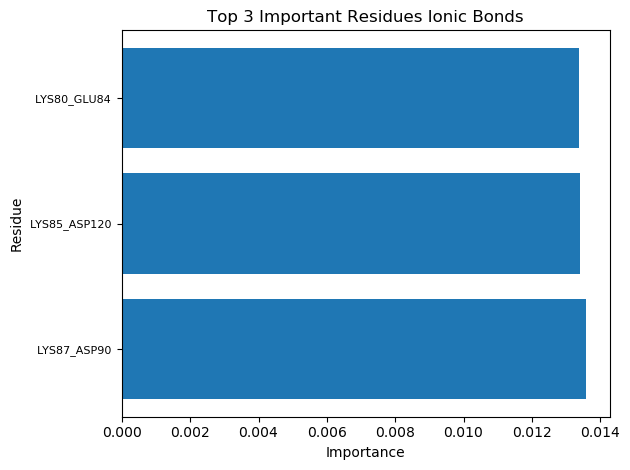

In [52]:

plot_residue_importance(X = dist, y = projs, bond_list=bond_names, N = 3, title = "Ionic Bonds", ncomp=3)

In [53]:
# functions

def pls_model(X, y, ncomp=3):

    # Normalize the data
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    y_reshaped = np.reshape(y, (-1, 1))
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_reshaped)

    # Build the PLS model
    opls = OPLS_PLS(pls_components=ncomp).fit(X, y)
   
    return opls

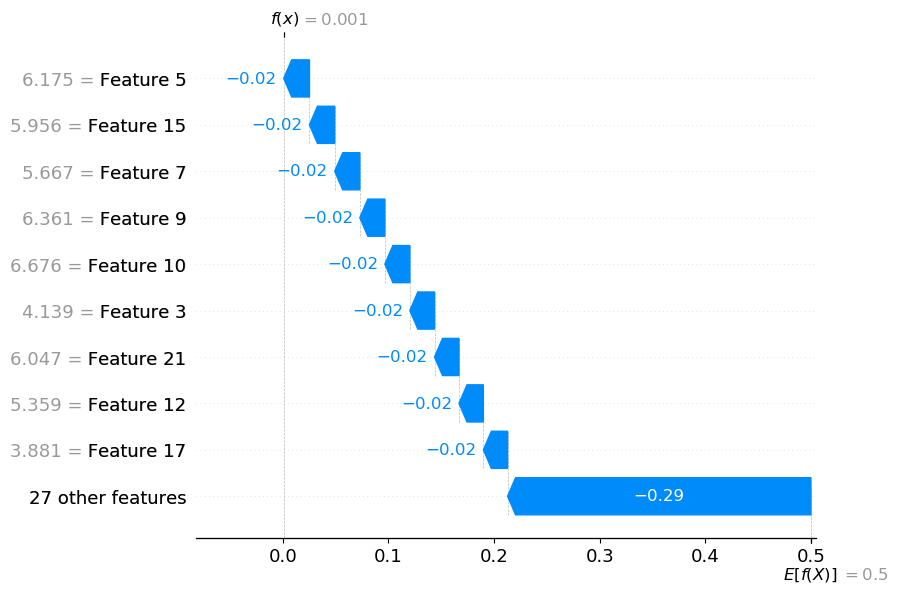

In [54]:
model = pls_model(X = dist, y = projs, ncomp=3)
# get shap values
explainer = shap.Explainer(model.predict, dist)
shap_values = explainer(dist)
#explainer = shap.Explainer(model)
#shap_values = explainer(X = dist)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [59]:


import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture as BGMM
import shap
import matplotlib.pyplot as plt



# Scale features for PLS regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist)



In [61]:
# Train PLS regression model
pls = PLSRegression(n_components=3)
pls.fit(X_scaled, projs)

# Compute predictions
y_pred = pls.predict(X_scaled)




In [62]:


# Compute SHAP values using LinearExplainer
explainer = shap.LinearExplainer(pls, X_scaled)
shap_values = explainer.shap_values(X_scaled)



In [ ]:


avg_shap_values = np.mean(np.abs(shap_values), axis=0)
avg_shap_df = pd.DataFrame({'Feature': housing.feature_names, 'Average_SHAP_Value': avg_shap_values}).sort_values(by='Average_SHAP_Value', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_shap_df)), avg_shap_df['Average_SHAP_Value'], tick_label=avg_shap_df['Feature'])
plt.xlabel('Feature')
plt.ylabel('Average SHAP Value')
plt.title('Average SHAP Values per Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('average_shap_bar_plot.png')

